# Track SP500 & UPRO

- This is based on the metric provided in:
  - https://plaxy314.blogspot.com
  - https://www.bogleheads.org/forum/viewtopic.php?t=319283&start=50

This notebook aimes to provide the metric data mentioned in the Bogleheads post. Will use it to guide my UPRO buy & sell decisions.

In [1]:
using HTTP, CSV, DataFrames
using Dates, Plots, Polynomials

## Step 1: Get SPY historical data to represent S&P500 data

In [2]:
api_key = ""
query_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&datatype=csv&apikey=$api_key"
data = HTTP.get(query_string).body |>
            String |>
            IOBuffer |>
            CSV.File |>
            DataFrame;

## Step 2: Fit the line and get the metric

I will simply use the daily close price. Followed the calculation posted in the Bogleheads:

- Let $P_t$ be the market price
- then take log of it: $p_t = log(P_t)$
- fit the log price by a stright line, e.g. in form of $y=a \times x + b$
  - this is considered as long term S&P500 average return
- adjust the log price by: $p^{adj}_t = p_t - y_t$
- assume S&P500 has yearly return of $7.5\%$, then $p^{year_adj}_t = p^{adj}_t / 0.075$
  - this transforms the price ahead/behind of long term average into a measure in years

Due to SPY data only starts from 1999, the S&P500 base line value has a bias compared to the post in Boglehead, but the trends are similar. But this should not matter given the plan is to holding the ETF for long term.

In [3]:
data.unix_timestamp = data.timestamp .|> DateTime .|> datetime2unix
data.log_close= log.(data.close)
data_fit = fit(data.unix_timestamp, data.log_close, 1)
data.adjusted_log_close = data.log_close .- data_fit.(data.unix_timestamp)
data.year_adjusted_log_close = data.adjusted_log_close ./ 0.075;

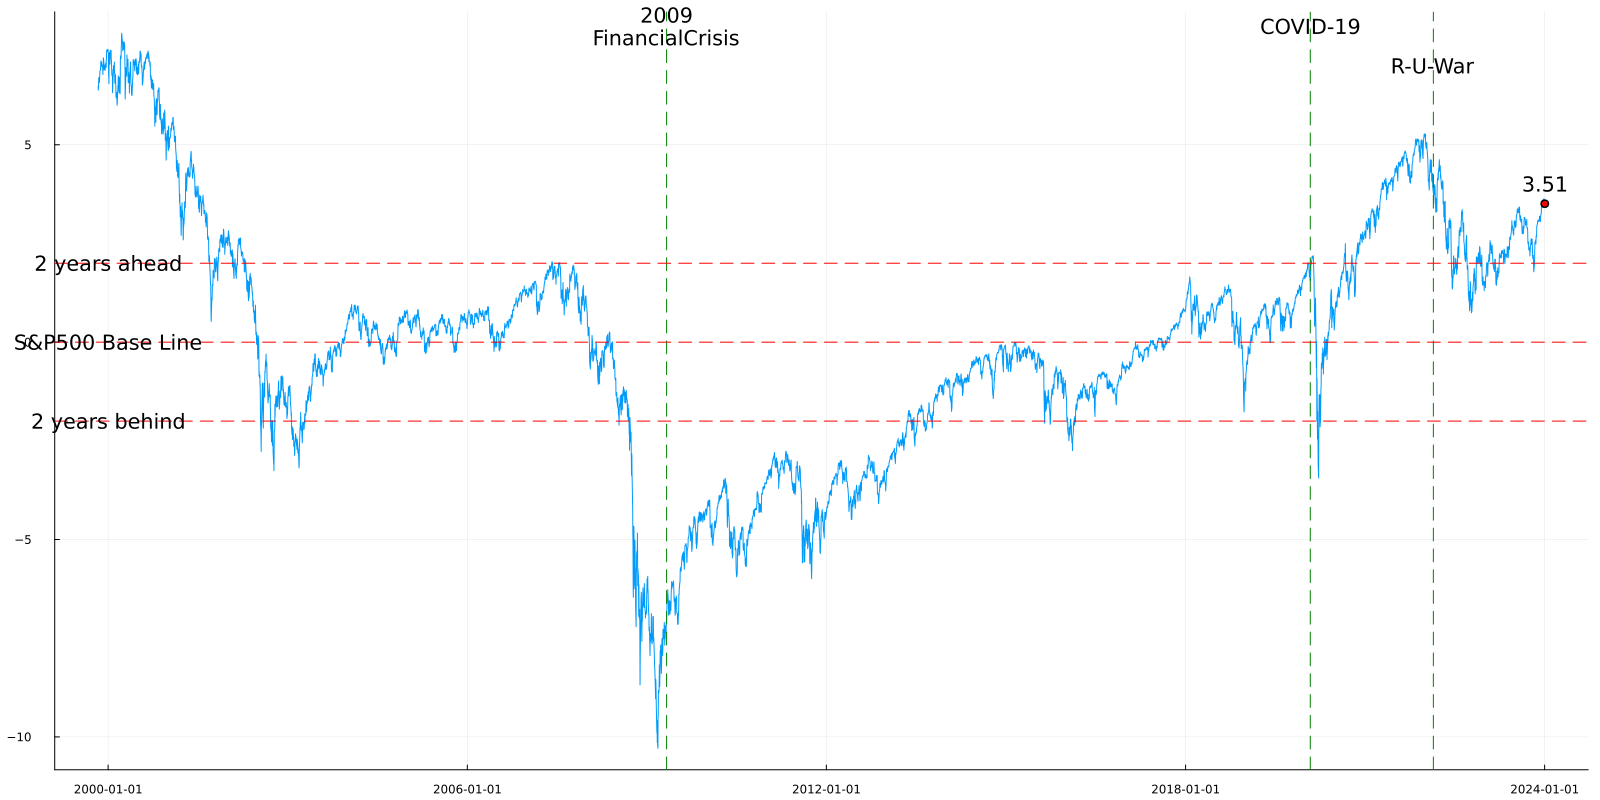

In [4]:
latest_plot = plot(data.timestamp, data.year_adjusted_log_close, label=false, size=(1600,800))

# Add special events to the plot
event1_date = Date("2009-05-01", "yyyy-mm-dd")
event1_name = "2009\nFinancialCrisis"
vline!([event1_date], color=:green, linestyle=:dash, label=false)
annotate!(event1_date, 8, text(event1_name))

event2_date = Date("2020-02-01", "yyyy-mm-dd")
event2_name = "COVID-19"
vline!([event2_date], color=:green, linestyle=:dash, label=false)
annotate!(event2_date, 8, text(event2_name))

event3_date = Date("2022-02-21", "yyyy-mm-dd")
event3_name = "R-U-War"
vline!([event3_date], color=:green, linestyle=:dash, label=false)
annotate!(event3_date, 7, text(event3_name))

# Add lines represent how many years the price is ahead or behind
date_annotate = Date("2000-01-01", "yyyy-mm-dd")
hline!([0], label=false, color=:red, linestyle=:dash)
annotate!(date_annotate, 0, text("S&P500 Base Line"))
hline!([2], label=false, color=:red, linestyle=:dash)
annotate!(date_annotate, 2, text("2 years ahead"))
hline!([-2], label=false, color=:red, linestyle=:dash)
annotate!(date_annotate, -2, text("2 years behind"))

# Add current price position with rounded year value
scatter!([data.timestamp[1]], [data.year_adjusted_log_close[1]], label=false, color=:red, markershape=:circle)
annotate!(data.timestamp[1], data.year_adjusted_log_close[1]+0.5, text("$(round(data.year_adjusted_log_close[1], digits=2))"))

# Save plot to file before display
file_name = "results/"*Dates.format(now(), "yyyy-mm-dd")*".png"
isfile(file_name) && rm(file_name)
savefig(latest_plot, file_name);

display(latest_plot)